# Takeaways
- Roundtrip works (TODO write tests)
- Write perf
    - No issues
- Read perf
    - 2.1s read_sql_table is fine, but ~7.5s to convert each feat col is too slow for server startup
    - Bottleneck is npy bytes -> np.array
    - But any optimization effort is a waste of time until we nail down how mobile will use the .sqlite payload...
    - TODO Revist once we have an idea how mobile will use search_recs
        - Will it want each array packed as bytes, like this?
        - Or will it want array elements manifested as sql data, e.g. so it can query them using sql?
        - Or something else entirely...?

In [ ]:
from notebooks import *
sg.init(None, skip=[sg_load.load_search_recs])
get_search_recs.cache_clear()

INFO     [19:25:56.086] [ 8110] 150 logging_/<module>: {logging_yaml: None}

INFO     [19:25:56.579] [ 8110]  32 api.server_globals/init

DEBUG    [19:25:56.586] [ 8110]  75 api.server_globals/load: load_search...

INFO     [19:25:56.950] [ 8110]  79 api.server_globals/load: load_search (took 0.358s)

DEBUG    [19:25:56.957] [ 8110]  75 api.server_globals/load: load_xc_meta...

INFO     [19:25:57.300] [ 8110]  79 api.server_globals/load: load_xc_meta (took 0.336s)

DEBUG    [19:25:57.307] [ 8110]  75 api.server_globals/load: load_feat_info...

INFO     [19:25:57.313] [ 8110] 110 api.server_globals/load_feat_info

INFO     [19:25:57.320] [ 8110]  79 api.server_globals/load: load_feat_info (took 0.007s)

WARNING  [19:25:57.327] [ 8110]  73 api.server_globals/load: load_search_recs [skipped]

INFO     [19:25:57.335] [ 8110]  34 api.server_globals/init: done

# Perf notes

Before
- Cold cache (warm pagecache but cold python proc)
```
search_recs(**{'cache_type': 'hybrid'})
INFO     [12:58:26.969] [37904] 600 api.recs/get_search_recs
INFO     [12:58:26.985] [37904] 118 payloads/df_cache_hybrid: Hit: payloads/search_recs-version[2],audio_s[10],countries_k[na],com_names_k[ca],num_recs[None]-9481fff
DEBUG    [12:58:26.994] [37904] 119 payloads/df_cache_hybrid: Hit [start]
DEBUG    [12:58:27.001] [37904] 129 payloads/df_cache_hybrid: Hit: Reading non_feats.parquet (1.8 GB)
INFO     [12:58:32.028] [37904] 136 payloads/df_cache_hybrid: Hit: Read non_feats.parquet (1.8 GB)
DEBUG    [12:58:32.040] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-f_preds.npy (46.6 MB)
INFO     [12:58:32.077] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-f_preds.npy: float32 (46.6 MB)
DEBUG    [12:58:32.084] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-feat.npy (211.4 MB)
INFO     [12:58:32.211] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-feat.npy: float32 (211.4 MB)
INFO     [12:58:32.218] [37904] 147 payloads/df_cache_hybrid: Hit: Join non_feats + feats
INFO     [12:58:32.469] [37904] 155 payloads/df_cache_hybrid: Hit [5.475s]
```

search_recs(**{'cache_type': 'hybrid'})

INFO     [19:25:57.531] [ 8110] 601 api.recs/get_search_recs

INFO     [19:25:57.546] [ 8110] 150 payloads/df_cache_hybrid: Hit: payloads/search_recs-version[4],audio_s[10],countries_k[na],com_names_k[ca],num_recs[None]-7993b24

DEBUG    [19:25:57.557] [ 8110] 151 payloads/df_cache_hybrid: Hit [start]

DEBUG    [19:25:57.564] [ 8110] 160 payloads/df_cache_hybrid: Hit: Reading lite.parquet (45.6 MB)

INFO     [19:25:59.361] [ 8110] 167 payloads/df_cache_hybrid: Hit: Read lite.parquet (45.6 MB)

DEBUG    [19:25:59.373] [ 8110] 173 payloads/df_cache_hybrid: Hit: Reading bytes-audio_bytes.parquet (1.4 GB)

INFO     [19:26:05.347] [ 8110] 180 payloads/df_cache_hybrid: Hit: Read bytes-audio_bytes.parquet (1.4 GB)

DEBUG    [19:26:05.408] [ 8110] 173 payloads/df_cache_hybrid: Hit: Reading bytes-spectro_bytes.parquet (382.8 MB)

INFO     [19:26:06.253] [ 8110] 180 payloads/df_cache_hybrid: Hit: Read bytes-spectro_bytes.parquet (382.8 MB)

DEBUG    [19:26:06.260] [ 8110] 186 payloads/df_cache_hybrid: Hit: Reading feat-f_preds.npy (46.6 MB)

INFO     [19:26:06.309] [ 8110] 188 payloads/df_cache_hybrid: Hit: Read feat-f_preds.npy: float32 (46.6 MB)

DEBUG    [19:26:06.315] [ 8110] 186 payloads/df_cache_hybrid: Hit: Reading feat-feat.npy (211.4 MB)

INFO     [19:26:06.487] [ 8110] 188 payloads/df_cache_hybrid: Hit: Read feat-feat.npy: float32 (211.4 MB)

INFO     [19:26:06.493] [ 8110] 192 payloads/df_cache_hybrid: Hit: Join lite + bytes + feats

INFO     [19:26:06.885] [ 8110] 203 payloads/df_cache_hybrid: Hit [9.328s]

DEBUG    [19:26:06.897] [ 8110] 211 payloads/df_cache_hybrid: Mobile: Writing payload [start]

DEBUG    [19:26:06.948] [ 8110] 237 payloads/df_cache_hybrid: Mobile: Materialize feat col: f_preds [start]

INFO     [19:26:11.736] [ 8110] 239 payloads/df_cache_hybrid: Mobile: Materialize feat col: f_preds [4.787s]

Mobile: Ensure dirs: audio_bytes: [

] |   0% (334) |  0.0s

Mobile: Ensure dirs: audio_bytes: [

##############################################################

] | 100% (334) |  0.1s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.0s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.2s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.3s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.4s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.5s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.6s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.8s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.9s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.0s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.1s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.2s

Mobile: Write files: audio_bytes: [

##                                                          

] |   4% (35231) |  1.3s

Mobile: Write files: audio_bytes: [

######                                                      

] |  11% (35231) |  1.4s

Mobile: Write files: audio_bytes: [

######                                                      

] |  11% (35231) |  1.6s

Mobile: Write files: audio_bytes: [

######                                                      

] |  11% (35231) |  1.7s

Mobile: Write files: audio_bytes: [

######                                                      

] |  11% (35231) |  1.8s

Mobile: Write files: audio_bytes: [

######                                                      

] |  11% (35231) |  1.9s

Mobile: Write files: audio_bytes: [

######                                                      

] |  11% (35231) |  2.0s

Mobile: Write files: audio_bytes: [

######                                                      

] |  11% (35231) |  2.2s

Mobile: Write files: audio_bytes: [

######                                                      

] |  11% (35231) |  2.3s

Mobile: Write files: audio_bytes: [

######                                                      

] |  11% (35231) |  2.4s

Mobile: Write files: audio_bytes: [

######                                                      

] |  11% (35231) |  2.5s

Mobile: Write files: audio_bytes: [

###########                                                 

] |  19% (35231) |  2.6s

Mobile: Write files: audio_bytes: [

#############                                               

] |  22% (35231) |  2.8s

Mobile: Write files: audio_bytes: [

#############                                               

] |  22% (35231) |  2.9s

Mobile: Write files: audio_bytes: [

#############                                               

] |  22% (35231) |  3.0s

Mobile: Write files: audio_bytes: [

#############                                               

] |  22% (35231) |  3.1s

Mobile: Write files: audio_bytes: [

#############                                               

] |  22% (35231) |  3.2s

Mobile: Write files: audio_bytes: [

#############                                               

] |  22% (35231) |  3.3s

Mobile: Write files: audio_bytes: [

#############                                               

] |  22% (35231) |  3.4s

Mobile: Write files: audio_bytes: [

#############                                               

] |  22% (35231) |  3.6s

Mobile: Write files: audio_bytes: [

#############                                               

] |  22% (35231) |  3.7s

Mobile: Write files: audio_bytes: [

#############                                               

] |  22% (35231) |  3.8s

Mobile: Write files: audio_bytes: [

##################                                          

] |  30% (35231) |  3.9s

Mobile: Write files: audio_bytes: [

##################                                          

] |  30% (35231) |  4.0s

Mobile: Write files: audio_bytes: [

##################                                          

] |  30% (35231) |  4.1s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  4.3s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  4.4s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  4.5s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  4.6s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  4.7s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  4.9s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  5.0s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  5.1s

Mobile: Write files: audio_bytes: [

####################                                        

] |  33% (35231) |  5.2s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  5.3s

Mobile: Write files: audio_bytes: [

#########################                                   

] |  41% (35231) |  5.4s

Mobile: Write files: audio_bytes: [

##########################                                  

] |  44% (35231) |  5.6s

Mobile: Write files: audio_bytes: [

##########################                                  

] |  44% (35231) |  5.7s

Mobile: Write files: audio_bytes: [

##########################                                  

] |  44% (35231) |  5.8s

Mobile: Write files: audio_bytes: [

##########################                                  

] |  44% (35231) |  5.9s

Mobile: Write files: audio_bytes: [

##########################                                  

] |  44% (35231) |  6.0s

Mobile: Write files: audio_bytes: [

##########################                                  

] |  44% (35231) |  6.2s

Mobile: Write files: audio_bytes: [

##########################                                  

] |  44% (35231) |  6.3s

Mobile: Write files: audio_bytes: [

##########################                                  

] |  44% (35231) |  6.4s

Mobile: Write files: audio_bytes: [

###########################                                 

] |  45% (35231) |  6.5s

Mobile: Write files: audio_bytes: [

###############################                             

] |  52% (35231) |  6.6s

Mobile: Write files: audio_bytes: [

################################                            

] |  54% (35231) |  6.7s

Mobile: Write files: audio_bytes: [

#################################                           

] |  55% (35231) |  6.8s

Mobile: Write files: audio_bytes: [

#################################                           

] |  55% (35231) |  7.0s

Mobile: Write files: audio_bytes: [

#################################                           

] |  55% (35231) |  7.1s

Mobile: Write files: audio_bytes: [

#################################                           

] |  55% (35231) |  7.2s

Mobile: Write files: audio_bytes: [

#################################                           

] |  55% (35231) |  7.3s

Mobile: Write files: audio_bytes: [

#################################                           

] |  55% (35231) |  7.4s

Mobile: Write files: audio_bytes: [

#################################                           

] |  55% (35231) |  7.5s

Mobile: Write files: audio_bytes: [

#################################                           

] |  55% (35231) |  7.7s

Mobile: Write files: audio_bytes: [

#####################################                       

] |  62% (35231) |  7.8s

Mobile: Write files: audio_bytes: [

######################################                      

] |  63% (35231) |  7.9s

Mobile: Write files: audio_bytes: [

######################################                      

] |  63% (35231) |  8.0s

Mobile: Write files: audio_bytes: [

######################################                      

] |  63% (35231) |  8.1s

Mobile: Write files: audio_bytes: [

######################################                      

] |  63% (35231) |  8.2s

Mobile: Write files: audio_bytes: [

######################################                      

] |  63% (35231) |  8.3s

Mobile: Write files: audio_bytes: [

######################################                      

] |  63% (35231) |  8.4s

Mobile: Write files: audio_bytes: [

######################################                      

] |  63% (35231) |  8.5s

Mobile: Write files: audio_bytes: [

######################################                      

] |  63% (35231) |  8.6s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  8.7s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  8.8s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  9.0s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  9.1s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  9.2s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  9.3s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  9.4s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  9.5s

Mobile: Write files: audio_bytes: [

########################################                    

] |  66% (35231) |  9.7s

Mobile: Write files: audio_bytes: [

############################################                

] |  73% (35231) |  9.8s

Mobile: Write files: audio_bytes: [

#############################################               

] |  75% (35231) |  9.9s

Mobile: Write files: audio_bytes: [

##############################################              

] |  77% (35231) | 10.0s

Mobile: Write files: audio_bytes: [

##############################################              

] |  77% (35231) | 10.1s

Mobile: Write files: audio_bytes: [

##############################################              

] |  77% (35231) | 10.2s

Mobile: Write files: audio_bytes: [

##############################################              

] |  77% (35231) | 10.4s

Mobile: Write files: audio_bytes: [

##############################################              

] |  77% (35231) | 10.5s

Mobile: Write files: audio_bytes: [

##############################################              

] |  77% (35231) | 10.6s

Mobile: Write files: audio_bytes: [

##############################################              

] |  77% (35231) | 10.7s

Mobile: Write files: audio_bytes: [

##############################################              

] |  77% (35231) | 10.8s

Mobile: Write files: audio_bytes: [

##############################################              

] |  77% (35231) | 10.9s

Mobile: Write files: audio_bytes: [

#################################################           

] |  81% (35231) | 11.1s

Mobile: Write files: audio_bytes: [

###################################################         

] |  86% (35231) | 11.2s

Mobile: Write files: audio_bytes: [

####################################################        

] |  87% (35231) | 11.4s

Mobile: Write files: audio_bytes: [

#####################################################       

] |  88% (35231) | 11.5s

Mobile: Write files: audio_bytes: [

#####################################################       

] |  88% (35231) | 11.6s

Mobile: Write files: audio_bytes: [

#####################################################       

] |  88% (35231) | 11.7s

Mobile: Write files: audio_bytes: [

#####################################################       

] |  88% (35231) | 11.9s

Mobile: Write files: audio_bytes: [

#####################################################       

] |  88% (35231) | 12.0s

Mobile: Write files: audio_bytes: [

#####################################################       

] |  88% (35231) | 12.1s

Mobile: Write files: audio_bytes: [

#####################################################       

] |  88% (35231) | 12.2s

Mobile: Write files: audio_bytes: [

#####################################################       

] |  88% (35231) | 12.3s

Mobile: Write files: audio_bytes: [

#######################################################     

] |  93% (35231) | 12.4s

Mobile: Write files: audio_bytes: [

############################################################

] | 100% (35231) | 12.5s

Mobile: Ensure dirs: spectro_bytes: [

] |   0% (334) |  0.0s

Mobile: Ensure dirs: spectro_bytes: [

############################################################

] | 100% (334) |  0.1s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.0s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.2s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.3s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.4s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.5s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.6s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.7s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.8s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.0s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.1s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.2s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.3s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.4s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.5s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.6s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.7s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.8s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  2.0s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  2.1s

Mobile: Write files: spectro_bytes: [

########                                                  

] |  15% (35231) |  2.2s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.3s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.4s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.5s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.6s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.7s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.9s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  3.0s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  3.1s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  3.2s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  3.3s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  3.4s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  3.5s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  3.6s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  3.7s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  3.8s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  3.9s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  4.1s

Mobile: Write files: spectro_bytes: [

#####################                                     

] |  37% (35231) |  4.2s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.3s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.4s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.5s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.6s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.7s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.8s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.9s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  5.1s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  5.2s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  5.3s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  5.4s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  5.5s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  5.6s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  5.7s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  5.8s

Mobile: Write files: spectro_bytes: [

###########################                               

] |  47% (35231) |  6.0s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.1s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.2s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.3s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.4s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.5s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.6s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.8s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.9s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  7.0s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  7.1s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  7.2s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  7.3s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  7.4s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  7.5s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  7.6s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  7.7s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  7.9s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  8.0s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  8.1s

Mobile: Write files: spectro_bytes: [

############################################              

] |  77% (35231) |  8.2s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  8.3s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  8.4s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  8.5s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  8.6s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  8.8s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  8.9s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  9.0s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  9.1s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  9.2s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  9.3s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  9.4s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  9.5s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  9.7s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  9.8s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  9.9s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) | 10.0s

Mobile: Write files: spectro_bytes: [

##########################################################

] | 100% (35231) | 10.1s

DEBUG    [19:26:50.643] [ 8110] 306 payloads/<dictcomp>: Mobile: Covert col for sql: json_dumps_canonical(background) (35231) [start]

INFO     [19:26:50.823] [ 8110] 306 payloads/<dictcomp>: Mobile: Covert col for sql: json_dumps_canonical(background) (35231) [0.179s]

DEBUG    [19:26:50.837] [ 8110] 306 payloads/<dictcomp>: Mobile: Covert col for sql: json_dumps_canonical(background_species) (35231) [start]

INFO     [19:26:51.014] [ 8110] 306 payloads/<dictcomp>: Mobile: Covert col for sql: json_dumps_canonical(background_species) (35231) [0.177s]

DEBUG    [19:26:51.095] [ 8110] 311 payloads/df_cache_hybrid: Mobile: Writing mobile/search_recs.sqlite3

INFO     [19:27:09.496] [ 8110] 319 payloads/df_cache_hybrid: Mobile: Wrote mobile/search_recs.sqlite3 (172.2 MB)

INFO     [19:27:09.753] [ 8110] 320 payloads/df_cache_hybrid: Mobile: Writing payload [62.855s]

,file,size
0,total,2098945907
1,bytes-audio_bytes.parquet,1412454635
2,bytes-spectro_bytes.parquet,382833212
4,feat-feat.npy: float32,211386128
3,feat-f_preds.npy: float32,46645972
0,lite.parquet,45625960


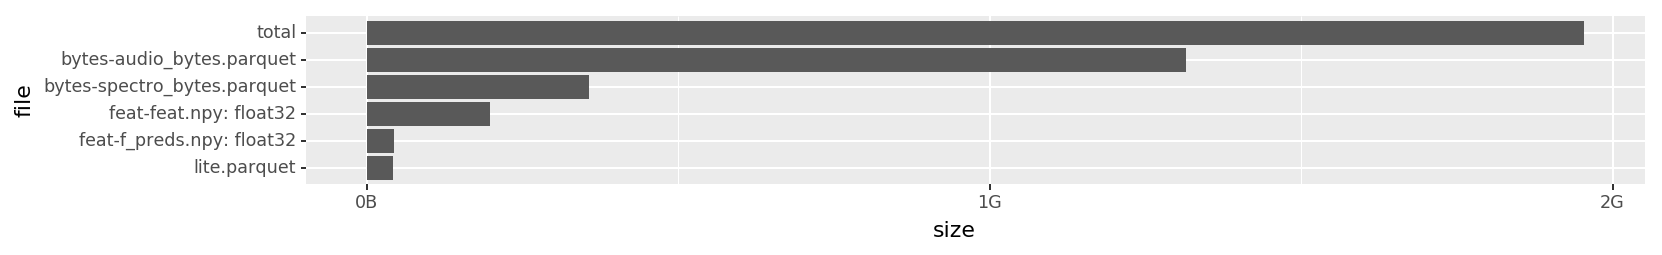

<ggplot: (-9223372036446566221)>

,file,size
0,total,1967079539
0,mobile/files/*/*-audio.*,1412223658
1,mobile/files/*/*-spectro.*,382664137
2,mobile/search_recs.sqlite3,172191744


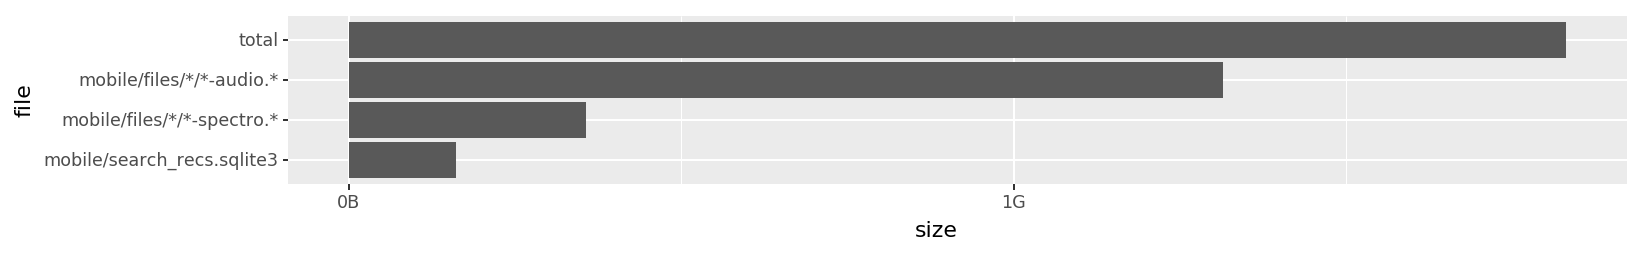

<ggplot: (412765339)>

,size,type,0
xc_id,36,int,413174
feat,104,ndarray,[ 9.259e-02 -3.927e-02 4.972e-01 -4.154e-04 -4.900e-02 -6.117e-02 3.974e-02 -1.629e-01 6.649e-02 -1.643e-02 -8.081e-02 -7.604e-02 -9.098e-02 4.766e-02 -4.830e-02 -6.90...
f_preds,104,ndarray,[3.219e-03 1.693e-03 4.284e-05 3.685e-03 1.657e-03 1.457e-02 9.939e-03 1.444e-03 2.617e-04 6.943e-04 4.435e-04 7.072e-04 2.569e-03 9.745e-03 8.396e-04 2.003e-03 7.801e-04 ...
background,80,list,['White-crowned Sparrow (Zonotrichia leucophrys)']
background_species,80,list,['WCSP']


In [ ]:
log_levels({
    # 'payloads': 'INFO',
    'payloads': 'DEBUG',
})
kwargss = [
    # dict(cache_type='hybrid', refresh=True),  # Simulate cache miss
    dict(cache_type='hybrid'),                # Simulate cache hit
]
search_recss = []
for kwargs in kwargss:
    print()
    print(f'search_recs(**{kwargs})')
    get_search_recs.cache_clear()
    search_recs = get_search_recs(**kwargs,
        write_mobile_payload=True,
        plot_sizes=True,
    )
    search_recss.append(search_recs)
    display(search_recs
        [['xc_id', 'feat', 'f_preds', 'background', 'background_species']]
        [2:3].reset_index(drop=True).T
        .pipe(df_assign_first,
            size=lambda df: df.T.memory_usage(deep=True),
            type=lambda df: df[0].map(lambda x: type(x).__name__),
        )
    )

In [ ]:
# TODO Turn this into unit tests
#   - Should roundtrip, should preserve category dtypes, should fail if index present
assert len(search_recss) == 2, "Test requires both 'cache hit' + 'cache miss' to be uncommented (above)"
[a, b] = search_recss
pd.testing.assert_frame_equal(a, b, check_column_type=True,
    check_index_type=False,  # Allow Int64Index vs. RangeIndex
)